In [53]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

import load

df = load.data("bird-message", season=[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])

df["fortification"] = load.stadium_attribute(df, 'fortification', center=True)
len(df)

109488

S12-S17, S19-S24:

threshold = 0.0125 - (centered fortification)

S18:

threshold = 0.015 - (centered fortification)

In [58]:
dfc = df.copy()
# dfc["ballpark_fortification"] = dfc["ballpark_fortification"] - 0.5
dfc = dfc[dfc["roll"] < 0.07]
dfc = dfc[dfc["season"] == 17]
# dfc = dfc[(dfc["season"] < 17) | (dfc["season"] > 18)]


In [64]:
X = dfc[
    [
        "roll",
        "passed",
        "fortification",
    ]
].copy()
y = X["passed"]
X = X.drop("passed", axis=1)

pin_intercept = 0.015
pins = [
    (-0.02, "fortification"),
]

for val, var in pins:
    X["roll"] -= X[var] * val
    X = X.drop(var, axis=1)


In [65]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:, 0] -= pin_intercept / sc.scale_[0]

trainedsvm = svm.LinearSVC(dual=False, max_iter=10000000, C=100000000, tol=1e-15, fit_intercept=pin_intercept is None).fit(
    X2, y
)
predictionsvm = trainedsvm.predict(X2)

print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))

[[606   0]
 [  0 203]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       606
        True       1.00      1.00      1.00       203

    accuracy                           1.00       809
   macro avg       1.00      1.00      1.00       809
weighted avg       1.00      1.00      1.00       809



In [66]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_ #- np.dot(coef, sc.mean_)
intercept_scaled = pin_intercept if pin_intercept is not None else -(intercept / coef[0, 0])[0]

dfc["threshold"] = intercept_scaled
print("intercept:", intercept_scaled)
for pair in pins + list(zip(-np.array(coef_list), X.columns)):
    if pair[1] != "roll":
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]


intercept: 0.015
(-0.02, 'fortification')


,offset,roll,fortification,threshold,passed,season,day,game_id,play_count
22501,-0.000314,0.012186,0.0,0.0125,False,12,60,64f43805-1317-467e-b92a-9e7579b2e275,362
22301,-0.000275,0.012225,0.0,0.0125,False,12,60,64f43805-1317-467e-b92a-9e7579b2e275,88


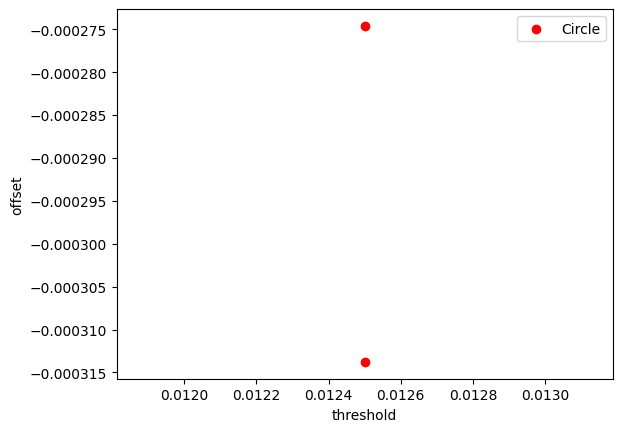

In [674]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]

fig, ax = plt.subplots(1)
x_val = "threshold"
y_val = "offset"
ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']][y_val], color="red", label="Circle")
ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']][y_val], color="blue", label="")
ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.legend()

table = outliers
table[["offset", "roll", "fortification", "threshold", "passed",
       "season", "day",  "game_id", "play_count"]].sort_values('offset')

# table["pitcher_file"]